# Section 1: Dataset Loading

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
import pandas as pd

# Load training dataset
train_df = pd.read_csv(
    "twitter_training.csv",
    header=None,
    names=["tweet_id", "entity", "sentiment", "text"]
)

# Load validation dataset
val_df = pd.read_csv(
    "twitter_validation.csv",
    header=None,
    names=["tweet_id", "entity", "sentiment", "text"]
)

In [189]:
print(train_df.shape)
print(val_df.shape)

train_df.head()

(74682, 4)
(1000, 4)


,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [191]:
combined_df = pd.concat(
    [train_df, val_df],
    axis=0,
    ignore_index=True
)

In [193]:
# Remove missing tweets
combined_df.dropna(subset=["text"], inplace=True)

# Remove duplicates
combined_df.drop_duplicates(inplace=True)

# Reset index
combined_df.reset_index(drop=True, inplace=True)

In [195]:
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72139 entries, 0 to 72138
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   72139 non-null  int64 
 1   entity     72139 non-null  object
 2   sentiment  72139 non-null  object
 3   text       72139 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [197]:
# Keep only sentiment and text
df = combined_df[["sentiment", "text"]].copy()

df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


## 1.1 Basic Statistical Summary

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72139 entries, 0 to 72138
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  72139 non-null  object
 1   text       72139 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [202]:
df['sentiment'].value_counts()

sentiment
Negative      21790
Positive      19846
Neutral       17879
Irrelevant    12624
Name: count, dtype: int64

In [204]:
# Remove rows where sentiment is 'Irrelevant'
df = df[df["sentiment"] != "Irrelevant"]

# Remove rows where sentiment is 'Neutral'
df = df[df["sentiment"] != "Neutral"]

# Reset index
df.reset_index(drop=True, inplace=True)

In [206]:
# Check percentage distribution of labels
df['sentiment'].value_counts(normalize=True) * 100

sentiment
Negative    52.334518
Positive    47.665482
Name: proportion, dtype: float64

In [208]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [210]:
# Count of each sentiment class
sentiment_counts = df['sentiment'].value_counts()
# Display counts
sentiment_counts

sentiment
Negative    21790
Positive    19846
Name: count, dtype: int64

## 1.2 Class balance check

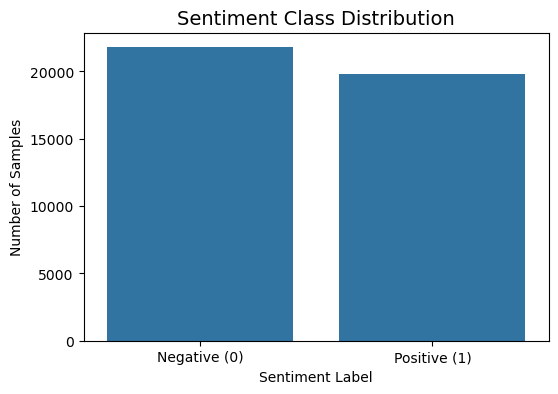

In [213]:
# Plot class distribution
plt.figure(figsize=(6,4))
sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values
)
plt.title("Sentiment Class Distribution", fontsize=14)
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.xticks([0,1], ['Negative (0)', 'Positive (1)'])
plt.show()

In [215]:
def check_dataset_balance(labels, threshold=0.20):
    
    class_dist = labels.value_counts(normalize=True)
    imbalance_ratio = class_dist.max() - class_dist.min()
    
    print("Class Distribution (Percentage):")
    print((class_dist * 100).round(2))
    print("\nImbalance Ratio:", round(imbalance_ratio * 100, 2), "%")
    
    # Balance decision
    if imbalance_ratio <= threshold:
        print("\n Dataset is BALANCED.")
    else:
        print("\n Dataset is IMBALANCED.")

check_dataset_balance(df['sentiment'])

Class Distribution (Percentage):
sentiment
Negative    52.33
Positive    47.67
Name: proportion, dtype: float64

Imbalance Ratio: 4.67 %

 Dataset is BALANCED.


# Section 2: Data Cleaning and Text Preprocessing

In [218]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/snehalsubedi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/snehalsubedi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/snehalsubedi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [220]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove numbers and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenization
    tokens = text.split()
    
    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

## 2.1 applying preprocessing to dataset

In [223]:
# Apply text cleaning to the Text column
df['cleaned_text'] = df['text'].apply(clean_text)

# Display sample comparison
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,im getting on borderlands and i will murder yo...,im getting borderland murder
1,I am coming to the borders and I will kill you...,coming border kill
2,im getting on borderlands and i will kill you ...,im getting borderland kill
3,im coming on borderlands and i will murder you...,im coming borderland murder
4,im getting on borderlands 2 and i will murder ...,im getting borderland murder


## 2.2 Text Length Analysis (Before & After Cleaning)

In [226]:
# Text length before cleaning
df['text_length_raw'] = df['text'].apply(lambda x: len(x.split()))

# Text length after cleaning
df['text_length_cleaned'] = df['cleaned_text'].apply(lambda x: len(x.split()))

# Display summary statistics
df[['text_length_raw', 'text_length_cleaned']].describe()

,text_length_raw,text_length_cleaned
count,41636.000000,41636.000000
mean,19.117543,10.567874
std,14.587663,7.803112
min,0.000000,0.000000
25%,8.000000,5.000000
50%,15.000000,9.000000
75%,27.000000,15.000000
max,198.000000,163.000000


## 2.3 Text Length Analysis – Seaborn & Matplotlib Visualizations

### 2.3.1 Histogram Comparison (Before vs After Cleaning) – Seaborn

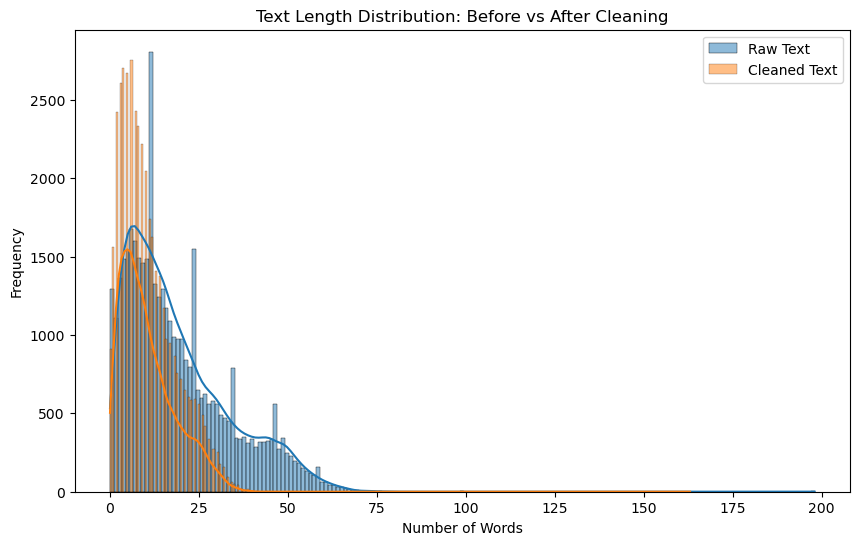

In [230]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df['text_length_raw'], label='Raw Text', kde=True)
sns.histplot(df['text_length_cleaned'], label='Cleaned Text', kde=True)
plt.legend()
plt.title("Text Length Distribution: Before vs After Cleaning")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

### 2.3.2 Boxplot Comparison – Seaborn

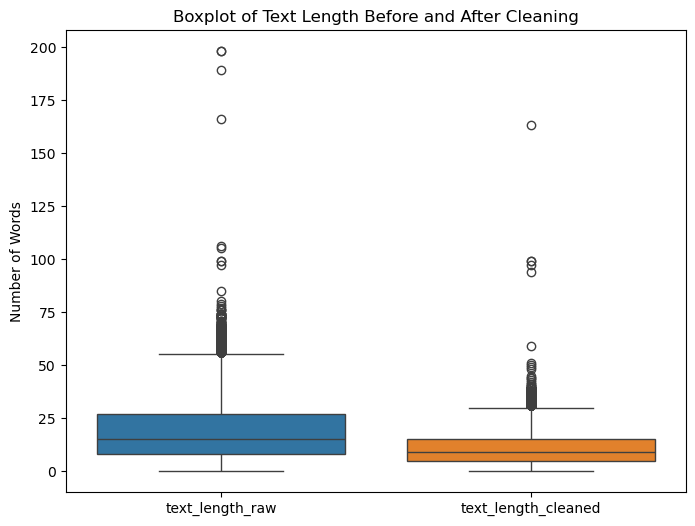

In [233]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[['text_length_raw', 'text_length_cleaned']])
plt.title("Boxplot of Text Length Before and After Cleaning")
plt.ylabel("Number of Words")
plt.show()

### 2.3.3 Violin Plot (Distribution Shape) – Seaborn

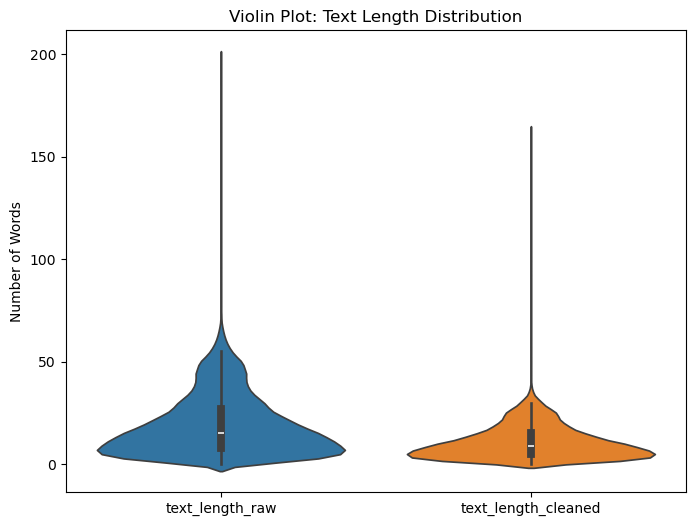

In [236]:
plt.figure(figsize=(8,6))
sns.violinplot(data=df[['text_length_raw', 'text_length_cleaned']])
plt.title("Violin Plot: Text Length Distribution")
plt.ylabel("Number of Words")
plt.show()

### 2.3.4 Mean Text Length Comparison – Matplotlib

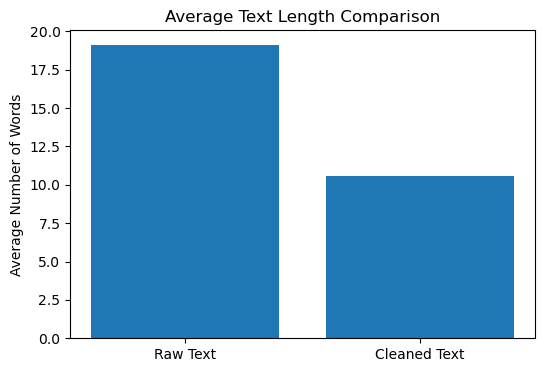

In [239]:
mean_raw = df['text_length_raw'].mean()
mean_cleaned = df['text_length_cleaned'].mean()

plt.figure(figsize=(6,4))
plt.bar(['Raw Text', 'Cleaned Text'], [mean_raw, mean_cleaned])
plt.title("Average Text Length Comparison")
plt.ylabel("Average Number of Words")
plt.show()

### 2.3.5 Label-wise Text Length

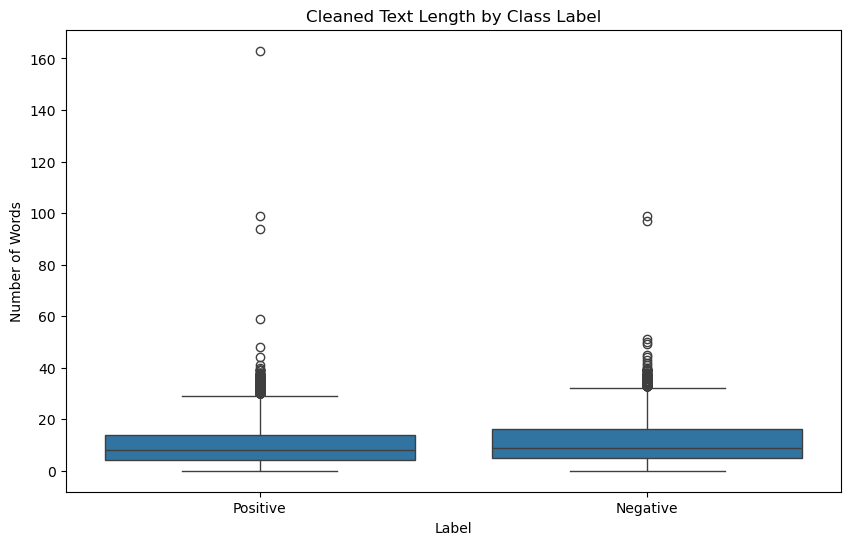

In [242]:
plt.figure(figsize=(10,6))
sns.boxplot(x='sentiment', y='text_length_cleaned', data=df)
plt.title("Cleaned Text Length by Class Label")
plt.xlabel("Label")
plt.ylabel("Number of Words")
plt.show()

# Section 3: Feature Engineering and model training

## 3.1 Feature and Target Separation

In [246]:
# Feature (independent variable)
X = df['cleaned_text']

# Target (dependent variable)
y = df['sentiment']

# Verify shapes
print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (41636,)
Target shape: (41636,)


In [248]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Encode target labels
y_encoded = label_encoder.fit_transform(y)

# Mapping check
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'Negative': 0, 'Positive': 1}

In [250]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

# Fit and transform text data
X_tfidf = tfidf.fit_transform(X)

# Check TF-IDF matrix shape
X_tfidf.shape

(41636, 5000)

## 3.2 Train–Test Split

In [253]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Verify split sizes
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (33308, 5000)
Testing set size: (8328, 5000)


## 3.3 Train Models on Training Data

In [256]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [258]:
# Initialize models
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42
)

naive_bayes = MultinomialNB()

In [260]:
# Train Logistic Regression
log_reg.fit(X_train, y_train)

# Train Naive Bayes
naive_bayes.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [262]:
# Predictions
y_pred_lr = log_reg.predict(X_test)
y_pred_nb = naive_bayes.predict(X_test)

In [264]:
# Training data predictions
y_train_pred_lr = log_reg.predict(X_train)
y_train_pred_nb = naive_bayes.predict(X_train)


In [266]:
from sklearn.metrics import classification_report

print("Baseline Logistic Regression – Training Data Classification Report:\n")
print(classification_report(y_train, y_train_pred_lr))


Baseline Logistic Regression – Training Data Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     17432
           1       0.88      0.89      0.89     15876

    accuracy                           0.89     33308
   macro avg       0.89      0.89      0.89     33308
weighted avg       0.89      0.89      0.89     33308



In [268]:
print("Baseline Naive Bayes – Training Data Classification Report:\n")
print(classification_report(y_train, y_train_pred_nb))


Baseline Naive Bayes – Training Data Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     17432
           1       0.87      0.83      0.85     15876

    accuracy                           0.86     33308
   macro avg       0.86      0.86      0.86     33308
weighted avg       0.86      0.86      0.86     33308



In [270]:
from sklearn.metrics import classification_report

print("Baseline Logistic Regression – Testing Data Classification Report:\n")
print(classification_report(y_test, y_pred_lr))


Baseline Logistic Regression – Testing Data Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4358
           1       0.86      0.86      0.86      3970

    accuracy                           0.86      8328
   macro avg       0.86      0.86      0.86      8328
weighted avg       0.86      0.86      0.86      8328



In [272]:
print("Baseline Naive Bayes – Testing Data Classification Report:\n")
print(classification_report(y_test, y_pred_nb))


Baseline Naive Bayes – Testing Data Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4358
           1       0.86      0.81      0.83      3970

    accuracy                           0.84      8328
   macro avg       0.84      0.84      0.84      8328
weighted avg       0.84      0.84      0.84      8328



# 4 Model Evaluation

## 4.1 Confusion Matrix Visualization

## Logistic Regression Confusion Matrix

In [277]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=[0, 1])

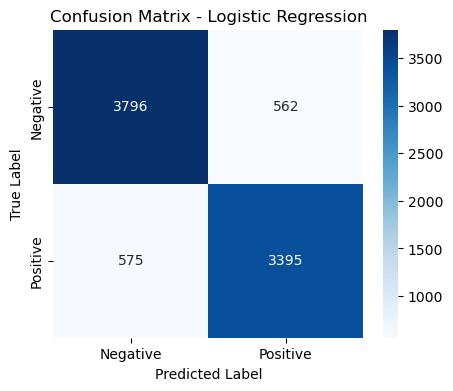

In [279]:
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative','Positive'],
    yticklabels=['Negative','Positive'],
)

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Naive Bayes Confusion Matrix

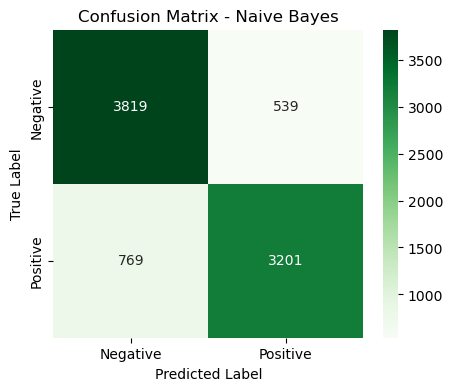

In [282]:
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Negative','Positive'],
    yticklabels=['Negative','Positive']
)

plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 4.2 ROC Curve and AUC Score

In [285]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_prob_lr = log_reg.predict_proba(X_test)[:,1]
y_prob_nb = naive_bayes.predict_proba(X_test)[:,1]

# Compute ROC values
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)

auc_lr = auc(fpr_lr, tpr_lr)
auc_nb = auc(fpr_nb, tpr_nb)

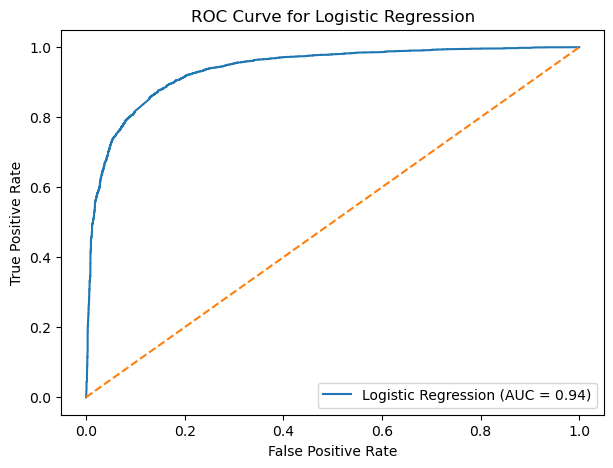

In [287]:
# Plot ROC curves for Logistic Regression
plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0,1], [0,1], linestyle='--')

plt.title("ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

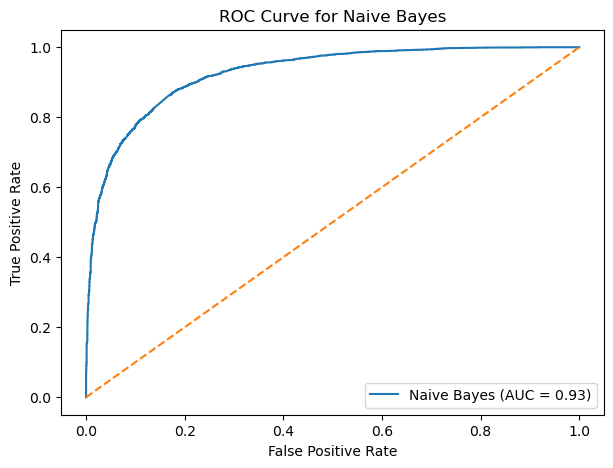

In [289]:
# Plot ROC curves for Naive Bayes
plt.figure(figsize=(7,5))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot([0,1], [0,1], linestyle='--')

plt.title("ROC Curve for Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

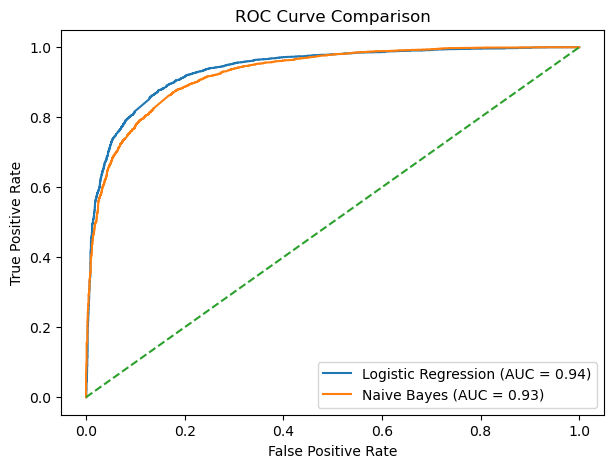

In [291]:
# Plot ROC curves
plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})')
plt.plot([0,1], [0,1], linestyle='--')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [293]:
# Create evaluation summary table
evaluation_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_nb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_nb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_nb)
    ],
    'AUC': [auc_lr, auc_nb]
})

evaluation_summary

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.863473,0.857973,0.855164,0.856566,0.936979
1,Naive Bayes,0.842939,0.855882,0.806297,0.830350,0.926423


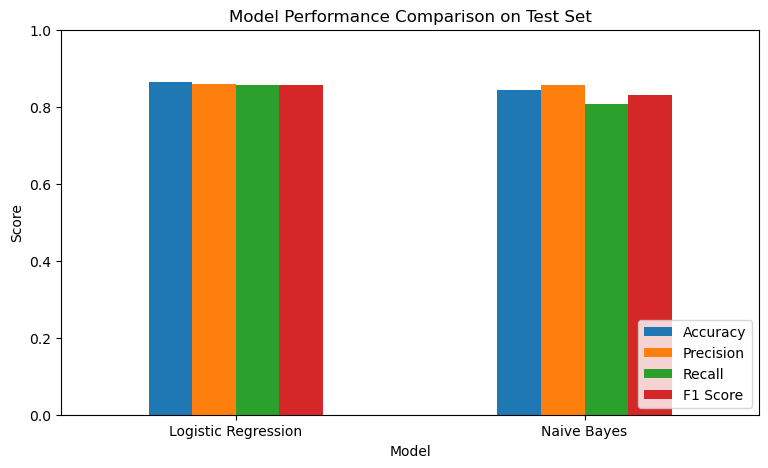

In [295]:
metrics_df = evaluation_summary.set_index('Model')

metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar',
    figsize=(9,5)
)

plt.title("Model Performance Comparison on Test Set")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# Section 5: Hyperparameter Tuning and Performance Enhancement

## 5.1 Hyperparameter Tuning: Logistic Regression

In [299]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Grid Search
lr_grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=lr_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit grid search
lr_grid.fit(X_train, y_train)

# Best parameters
lr_grid.best_params_

{'C': 10, 'solver': 'liblinear'}

In [301]:
best_lr = lr_grid.best_estimator_

## 5.2 Hyperparameter Tuning: Naive Bayes

In [304]:
nb_param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

# Grid Search
nb_grid = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=nb_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit grid search
nb_grid.fit(X_train, y_train)

# Best parameters
nb_grid.best_params_

{'alpha': 0.01}

In [306]:
best_nb = nb_grid.best_estimator_

## 5.3 Evaluate Tuned Models on Test Set

In [309]:
y_pred_lr_tuned = best_lr.predict(X_test)
y_pred_nb_tuned = best_nb.predict(X_test)

## 5.4 Performance Comparison: Before vs After Tuning

In [312]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create comparison table
tuning_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes'],
    
    'Accuracy (Before)': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb)
    ],
    'Accuracy (After)': [
        accuracy_score(y_test, y_pred_lr_tuned),
        accuracy_score(y_test, y_pred_nb_tuned)
    ],
    
    'F1 Score (Before)': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_nb)
    ],
    'F1 Score (After)': [
        f1_score(y_test, y_pred_lr_tuned),
        f1_score(y_test, y_pred_nb_tuned)
    ]
})

tuning_comparison

,Model,Accuracy (Before),Accuracy (After),F1 Score (Before),F1 Score (After)
0,Logistic Regression,0.863473,0.883525,0.856566,0.878507
1,Naive Bayes,0.842939,0.846542,0.830350,0.834198


In [316]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- Predicted probabilities (needed for AUC) ---
# Untuned
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
y_prob_nb = naive_bayes.predict_proba(X_test)[:, 1]

# Tuned
y_prob_lr_tuned = best_lr.predict_proba(X_test)[:, 1]
y_prob_nb_tuned = best_nb.predict_proba(X_test)[:, 1]

tuning_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes'],

    'Accuracy (Before)': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb)
    ],
    'Accuracy (After)': [
        accuracy_score(y_test, y_pred_lr_tuned),
        accuracy_score(y_test, y_pred_nb_tuned)
    ],

    'Precision (Before)': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_nb)
    ],
    'Precision (After)': [
        precision_score(y_test, y_pred_lr_tuned),
        precision_score(y_test, y_pred_nb_tuned)
    ],

    'Recall (Before)': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_nb)
    ],
    'Recall (After)': [
        recall_score(y_test, y_pred_lr_tuned),
        recall_score(y_test, y_pred_nb_tuned)
    ],

    'F1 Score (Before)': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_nb)
    ],
    'F1 Score (After)': [
        f1_score(y_test, y_pred_lr_tuned),
        f1_score(y_test, y_pred_nb_tuned)
    ],

    'AUC (Before)': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_nb)
    ],
    'AUC (After)': [
        roc_auc_score(y_test, y_prob_lr_tuned),
        roc_auc_score(y_test, y_prob_nb_tuned)
    ],
})

tuning_comparison


,Model,Accuracy (Before),Accuracy (After),Precision (Before),Precision (After),Recall (Before),Recall (After),F1 Score (Before),F1 Score (After),AUC (Before),AUC (After)
0,Logistic Regression,0.863473,0.883525,0.857973,0.873692,0.855164,0.883375,0.856566,0.878507,0.936979,0.954414
1,Naive Bayes,0.842939,0.846542,0.855882,0.860086,0.806297,0.809824,0.830350,0.834198,0.926423,0.931149


## 5.5 Visualization: Impact of Hyperparameter Tuning

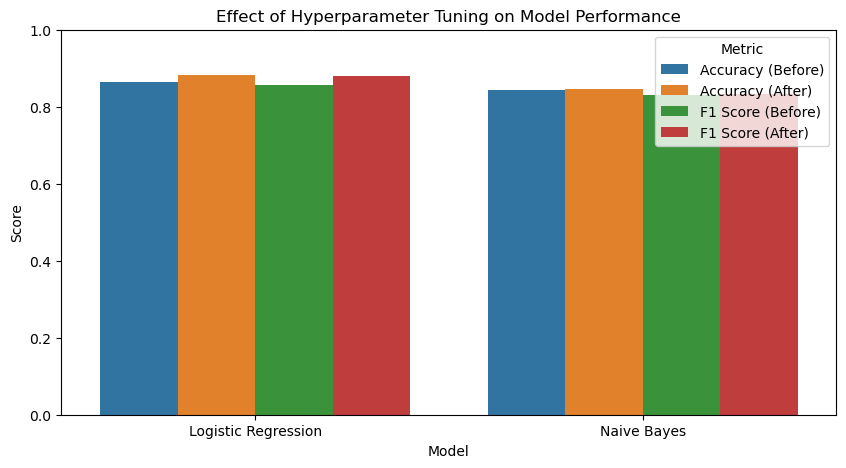

In [319]:
plot_df = tuning_comparison.melt(
    id_vars='Model',
    value_vars=['Accuracy (Before)', 'Accuracy (After)', 
                'F1 Score (Before)', 'F1 Score (After)'],
    var_name='Metric',
    value_name='Score'
)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(
    x='Model',
    y='Score',
    hue='Metric',
    data=plot_df
)

plt.title("Effect of Hyperparameter Tuning on Model Performance")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()

## 5.6 Hyperparameter Value vs Performance (Line Plot)

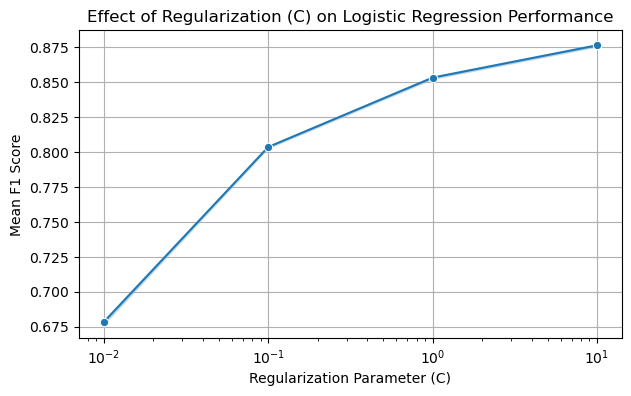

In [322]:
lr_results = pd.DataFrame(lr_grid.cv_results_)

# Plot C vs mean F1 score
plt.figure(figsize=(7,4))
sns.lineplot(
    x=lr_results['param_C'].astype(float),
    y=lr_results['mean_test_score'],
    marker='o'
)

plt.xscale('log')
plt.xlabel("Regularization Parameter (C)")
plt.ylabel("Mean F1 Score")
plt.title("Effect of Regularization (C) on Logistic Regression Performance")
plt.grid(True)
plt.show()

## 5.7 Naive Bayes Smoothing Effect (Line Plot)

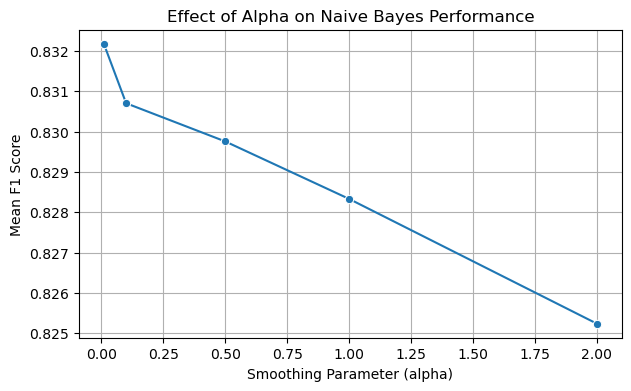

In [325]:
# Extract NB GridSearch results
nb_results = pd.DataFrame(nb_grid.cv_results_)

plt.figure(figsize=(7,4))
sns.lineplot(
    x=nb_results['param_alpha'].astype(float),
    y=nb_results['mean_test_score'],
    marker='o'
)

plt.xlabel("Smoothing Parameter (alpha)")
plt.ylabel("Mean F1 Score")
plt.title("Effect of Alpha on Naive Bayes Performance")
plt.grid(True)
plt.show()

## 5.8 ROC Curve: Tuned vs Untuned Logistic Regression

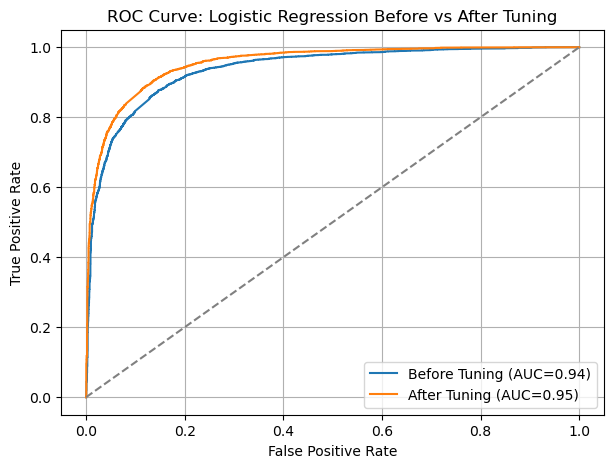

In [328]:
# Predicted probabilities
y_prob_lr_tuned = best_lr.predict_proba(X_test)[:,1]

fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_lr_tuned)
auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Before Tuning (AUC={auc_lr:.2f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'After Tuning (AUC={auc_tuned:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression Before vs After Tuning")
plt.legend()
plt.grid(True)
plt.show()

## 5.9 ROC Curve: Tuned vs Untuned Naive Bayes

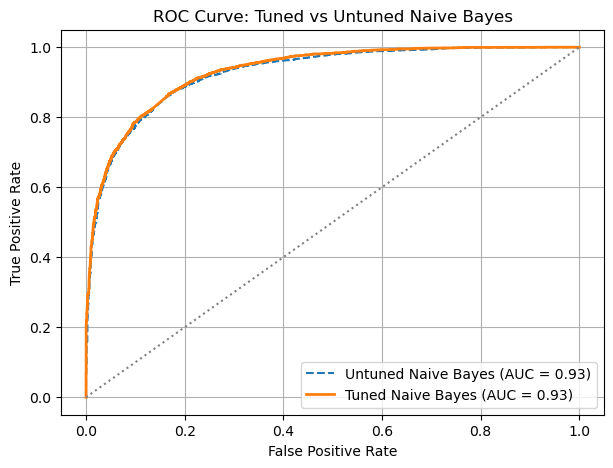

In [331]:
from sklearn.metrics import roc_curve, auc

# Untuned Naive Bayes probabilities
y_prob_nb_untuned = naive_bayes.predict_proba(X_test)[:, 1]

# Tuned Naive Bayes probabilities
y_prob_nb_tuned = best_nb.predict_proba(X_test)[:, 1]

# ROC values
fpr_nb_untuned, tpr_nb_untuned, _ = roc_curve(y_test, y_prob_nb_untuned)
fpr_nb_tuned, tpr_nb_tuned, _ = roc_curve(y_test, y_prob_nb_tuned)

# AUC scores
auc_nb_untuned = auc(fpr_nb_untuned, tpr_nb_untuned)
auc_nb_tuned = auc(fpr_nb_tuned, tpr_nb_tuned)

# Plot ROC curves
plt.figure(figsize=(7,5))

plt.plot(
    fpr_nb_untuned, tpr_nb_untuned,
    linestyle='--',
    label=f'Untuned Naive Bayes (AUC = {auc_nb_untuned:.2f})'
)

plt.plot(
    fpr_nb_tuned, tpr_nb_tuned,
    linewidth=2,
    label=f'Tuned Naive Bayes (AUC = {auc_nb_tuned:.2f})'
)

plt.plot([0,1], [0,1], linestyle=':', color='gray')

plt.title("ROC Curve: Tuned vs Untuned Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## 6. Learning Curve 

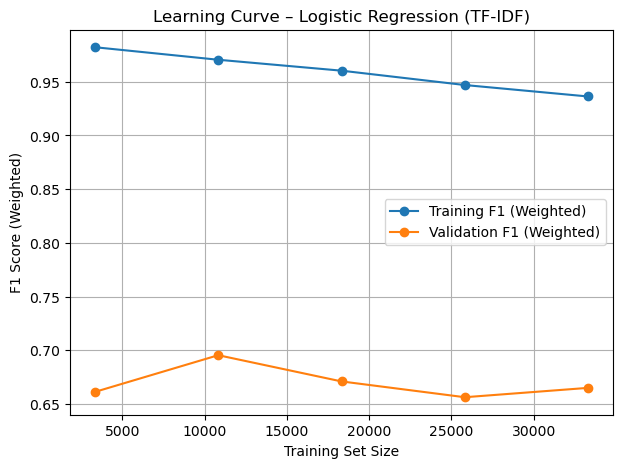

In [334]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Use tuned LR params if best_lr exists, otherwise default LR
try:
    lr_model = LogisticRegression(
        C=best_lr.C,
        penalty=best_lr.penalty,
        solver=best_lr.solver,
        max_iter=1000
    )
except NameError:
    lr_model = LogisticRegression(max_iter=1000)

# Pipeline: TF-IDF + Logistic Regression (matches your TF-IDF settings)
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('lr', lr_model)
])

train_sizes, train_scores, val_scores = learning_curve(
    pipeline_lr,
    df['cleaned_text'],      # X (raw cleaned text)
    y_encoded,               # y (encoded sentiment labels)
    cv=5,
    scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1 (Weighted)')
plt.plot(train_sizes, val_mean, marker='o', label='Validation F1 (Weighted)')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score (Weighted)")
plt.title("Learning Curve – Logistic Regression (TF-IDF)")
plt.legend()
plt.grid(True)
plt.show()


## 7. Sample Prediction 

In [337]:
def show_sample_predictions_from_df(model, tfidf, df, label_encoder, n=5, random_state=42):
    # pick random samples so it looks more realistic in report
    sample_df = df.sample(n=n, random_state=random_state)

    sample_texts = sample_df['cleaned_text']
    true_labels = sample_df['sentiment'].values

    # TF-IDF transform using the fitted vectorizer
    sample_vectors = tfidf.transform(sample_texts)

    # Predict encoded labels then convert back to original sentiment names
    pred_encoded = model.predict(sample_vectors)
    pred_labels = label_encoder.inverse_transform(pred_encoded)

    for i in range(n):
        print("Tweet:", sample_texts.iloc[i])
        print("True Sentiment:", true_labels[i])
        print("Predicted Sentiment:", pred_labels[i])
        print("-" * 60)

# Run sample predictions using tuned Logistic Regression
show_sample_predictions_from_df(best_lr, tfidf, df, label_encoder, n=5)


Tweet: see rhandlerr rhandlerr rhandlerr got back hearthstone long break getting used meta got legend quickly end last month week mainly optimizing galakrond zoo warlock kronx suck bait card deck faceless max pictwittercomfnvtybi
True Sentiment: Positive
Predicted Sentiment: Positive
------------------------------------------------------------
Tweet: fuck microsoft screw nvidia im losing mind right
True Sentiment: Negative
Predicted Sentiment: Negative
------------------------------------------------------------
Tweet: know bad unless looking forward watching trent v sterling regularly fifa
True Sentiment: Negative
Predicted Sentiment: Negative
------------------------------------------------------------
Tweet: battlefield brigade looked really good
True Sentiment: Positive
Predicted Sentiment: Positive
------------------------------------------------------------
Tweet: ghostrecon u guy please add camera zoom great game resent close camera
True Sentiment: Negative
Predicted Sentiment: 

## 8. Feature Visualization

In [340]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_words(scores, feature_names, title, top_n=20):
    idx = np.argsort(scores)[-top_n:]
    top_features = np.array(feature_names)[idx]
    top_scores = scores[idx]

    plt.figure(figsize=(10,6))
    plt.barh(top_features, top_scores)
    plt.title(title)
    plt.xlabel("Importance (higher = more indicative)")
    plt.tight_layout()
    plt.show()


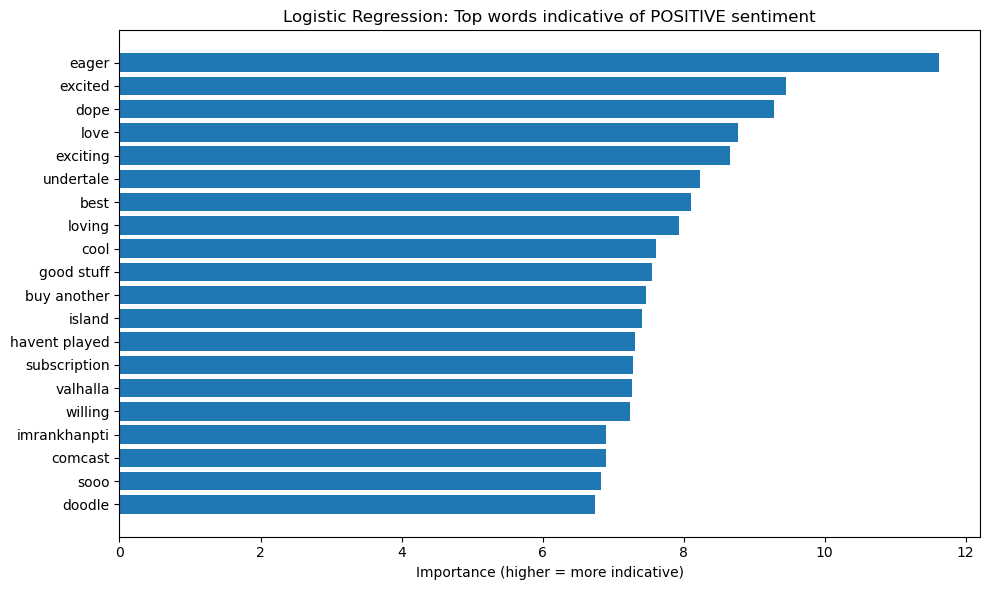

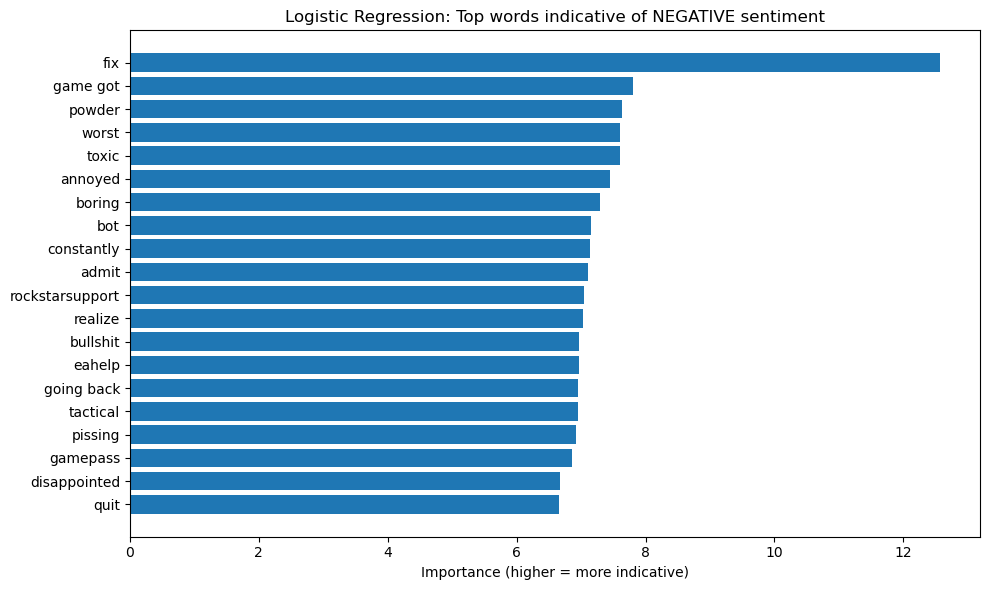

In [342]:
# Logistic Regression (Binary Sentiment)
lr = best_lr
feature_names = tfidf.get_feature_names_out()

# coef_ shape: (1, n_features) for binary LR
coefs = lr.coef_.ravel()

# class order from model (usually [0, 1])
classes = list(lr.classes_)

# determine index for Positive class
positive_index = classes.index(1) if 1 in classes else 1

# If class 1 is Positive → positive coefficients = Positive sentiment
positive_scores = coefs
negative_scores = -coefs

plot_top_words(positive_scores, feature_names,
               "Logistic Regression: Top words indicative of POSITIVE sentiment",
               top_n=20)

plot_top_words(negative_scores, feature_names,
               "Logistic Regression: Top words indicative of NEGATIVE sentiment",
               top_n=20)


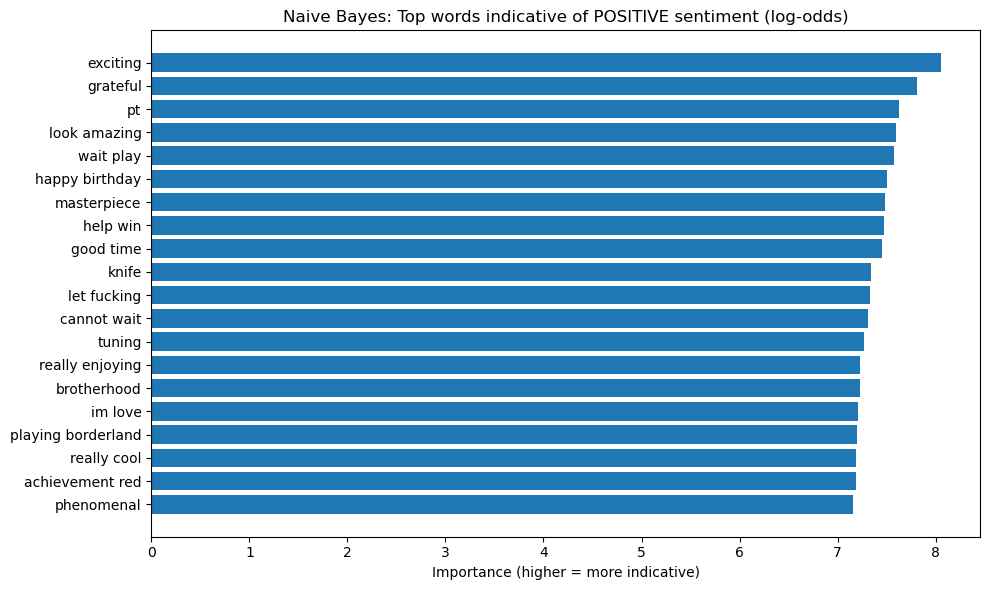

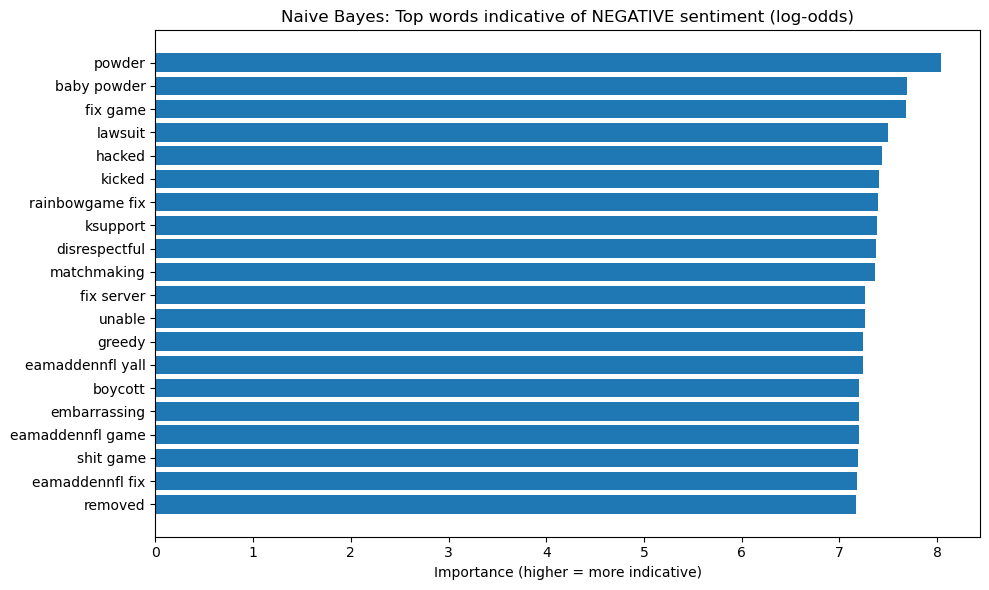

In [344]:
# Naive Bayes (Binary Sentiment)
nb = best_nb
feature_names = tfidf.get_feature_names_out()

# feature_log_prob_ shape: (2, n_features)
classes = list(nb.classes_)

# indices for Negative (0) and Positive (1)
neg_i = classes.index(0)
pos_i = classes.index(1)

# log-odds: log P(word|Positive) - log P(word|Negative)
log_odds = nb.feature_log_prob_[pos_i] - nb.feature_log_prob_[neg_i]

plot_top_words(log_odds, feature_names,
               "Naive Bayes: Top words indicative of POSITIVE sentiment (log-odds)",
               top_n=20)

plot_top_words(-log_odds, feature_names,
               "Naive Bayes: Top words indicative of NEGATIVE sentiment (log-odds)",
               top_n=20)


## 9. Word Cloud

In [347]:
# Install (run once)
!pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


In [349]:
# Separate text by sentiment (STRING labels)
positive_text = " ".join(
    df[df['sentiment'] == "Positive"]['cleaned_text']
    .dropna()
    .astype(str)
)

negative_text = " ".join(
    df[df['sentiment'] == "Negative"]['cleaned_text']
    .dropna()
    .astype(str)
)

print("Positive length:", len(positive_text))
print("Negative length:", len(negative_text))



Positive length: 1306525
Negative length: 1634196


In [351]:
# Stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "rt", "amp", "u", "ur", "im", "dont", "cant", "will", "just"
])


In [353]:
# FIXED plotting function (Python 3.12 compatible)
def plot_wordcloud(text, title):
    wc = WordCloud(
        width=1200,
        height=600,
        background_color="white",
        stopwords=custom_stopwords,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(12,6))
    plt.imshow(wc.to_image(), interpolation="bilinear")  
    plt.axis("off")
    plt.title(title)
    plt.show()


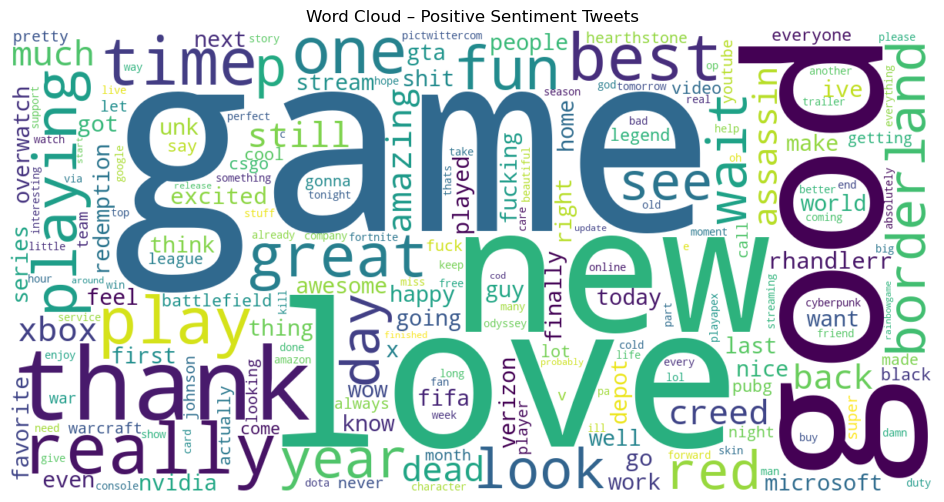

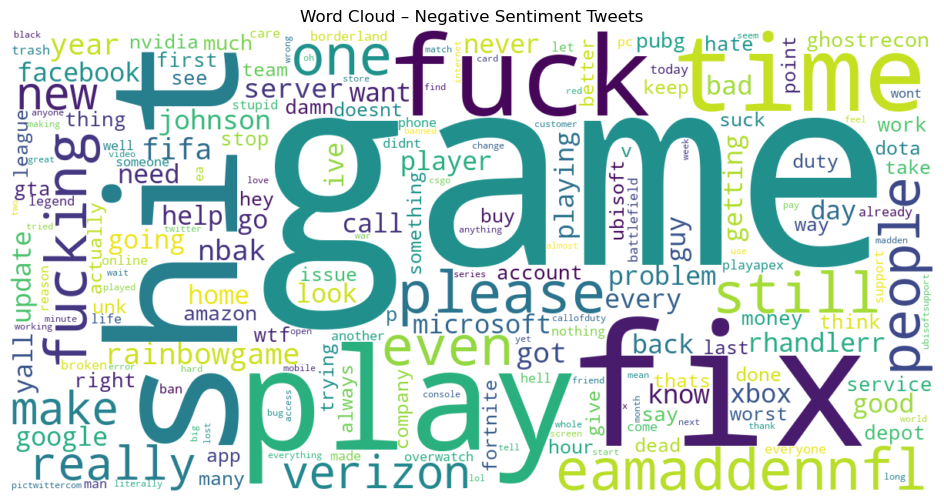

In [355]:
# Generate Word Clouds
plot_wordcloud(positive_text, "Word Cloud – Positive Sentiment Tweets")
plot_wordcloud(negative_text, "Word Cloud – Negative Sentiment Tweets")
